In [1]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def set_up():
    """
    Initial directories and vars set-up.
    
    Returns:
        A tuple containing:
            - ORIGINAL_DATA_DIR....Directory where we have the data provided in the handout.
            - BERT_FEATURE_DIR.....Directory where we saved the bert features representation of the data.
    """
    ORIGINAL_DATA_DIR = os.path.join("data")
    BERT_FEATURE_DIR = os.path.join("..", "bert", "bert_output_data")
    IMAGE_DATA_DIR = os.path.join("images")
    return (ORIGINAL_DATA_DIR, BERT_FEATURE_DIR, IMAGE_DATA_DIR)

In [ ]:
ORIGINAL_DATA_DIR, BERT_FEATURE_DIR, IMAGE_DATA_DIR = set_up()
print("Data Directory provided in the handout is: %s" % ORIGINAL_DATA_DIR)
print("Data Directory where feature vectors generated by bert extract_features.py are saved is: %s" % BERT_FEATURE_DIR)
print("Image Directory is: %s" % IMAGE_DATA_DIR)

In [3]:
def read_csv(directory, filename):
    """
    Read a csv file using pandas.
    
    Params:
        - directory....The directory where that file is stored.
        - filename.....The name of the file ot be read
    
    Returns:
        A pandas dataframe containing the csv info.
    """
    return pd.read_csv(os.path.join(directory, filename))

In [ ]:
train_df = read_csv(ORIGINAL_DATA_DIR, "lang_id_train.csv")
test_df = read_csv(ORIGINAL_DATA_DIR, "lang_id_test.csv")
eval_df = read_csv(ORIGINAL_DATA_DIR, "lang_id_eval.csv")

In [4]:
def load_bert_features(filename_list=["train", "test", "eval"], bert_dir=os.path.join("data")):
    """
    Load generated bert features files for a specific file.
    
    Params:
        - filename_list...The list of filenames for which we want to load the feature representations generated by bert.
        - bert_dir........The directory where we saved the output files when we executed bert extract features script.
    
    Returns:
        A dict conataining as keys the filenames and values the features representation for each input for each file.
    """
    bert_vectors_dict = {}
    for filename in filename_list:
        bert_vectors = []
        with open(os.path.join(bert_dir, filename+".jsonlines"), "rt") as infile:
            for line in infile:
                bert_data = json.loads(line)
                for t in bert_data["features"]:
                    # Only extract the [CLS] vector used for classification
                    if t["token"] == "[CLS]":
                        # We only use the representation at the final layer of the network
                        bert_vectors.append(t["layers"][0]["values"])
                        break
        bert_vectors_dict[filename] = bert_vectors
    return bert_vectors_dict

In [ ]:
bert_vectors = load_bert_features(["train", "test", "eval"], BERT_FEATURE_DIR)

In [5]:
def get_clf(c=1.0, penalty='l2'):
    """
    Function for creation a Logistic Regression model with secific parameters.
    
    Params:
        - c..........Regularization parameter.
        - penalty....Norm used in penalization.
    
    Returns:
        A Logistic Regression object with the specified parameters.
    """
    return LogisticRegression(random_state=42, C=c, penalty=penalty)

In [6]:
def train_and_evaluate_model(bert_vectors, train_df, test_df, eval_df, c=1.0, penalty='l2'):
    """
    Train the Logistic Regression model using the bert vectors as input data for the model, and the labeled
    data to check accuracy of the model.
    
    Params:
        - bert_vectors...List of bert_features for each text.
        - train_df.......The labeled original dataframe of the train set.
        - test_df.......The labeled original dataframe of the test set.
        - eval_df.......The labeled original dataframe of the eval set.
        - c..............Regularization parameter.
        - penalty........Norm used in penalization.
    Return:
        A tuple containing:
            - The Logistic Regression model.
            - A dict containing the results of the evaluation for each dataset.
    """
    # Obtan all x and y for each datset.
    X_train = np.array(bert_vectors["train"])
    y_train =  train_df["native_language"].values
    X_test = np.array(bert_vectors["test"])
    y_test =  test_df["native_language"].values
    X_eval = np.array(bert_vectors["eval"])
    y_eval =  eval_df["native_language"].values
    
    #  Create Logistic Regression model and train it.
    clf = get_clf(c=c, penalty=penalty)
    clf.fit(X_train, y_train)
    
    # Predict classes oer all datasets
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)
    y_hat_eval = clf.predict(X_eval)
    
    # Compute accuracy for each dataset
    eval_accuracies = []
    test_accuracies = []
    train_accuracies = []
    train_accuracies.append(accuracy_score(y_hat_train, y_train))
    test_accuracies.append(accuracy_score(y_hat_test, y_test))
    eval_accuracies.append(accuracy_score(y_hat_eval, y_eval))
    
    # Create Results dict to save the evaluation metrics for each dataset
    results = defaultdict(dict)
    results["train"]["y_label"] = y_train
    results["train"]["y_hat"] = y_hat_train
    results["train"]["accuracies"] = train_accuracies
    results["train"]["conf_matrix"] = confusion_matrix(y_train, y_hat_train)
    results["train"]["class_metrics"] = classification_report(y_train, y_hat_train, output_dict=True)
    results["test"]["y_label"] = y_test
    results["test"]["y_hat"] = y_hat_test
    results["test"]["accuracies"] = test_accuracies
    results["test"]["conf_matrix"] = confusion_matrix(y_test, y_hat_test)
    results["test"]["class_metrics"] = classification_report(y_test, y_hat_test, output_dict=True)
    results["eval"]["y_label"] = y_eval
    results["eval"]["y_hat"] = y_hat_eval
    results["eval"]["accuracies"] = eval_accuracies
    results["eval"]["conf_matrix"] = confusion_matrix(y_eval, y_hat_eval)
    results["eval"]["class_metrics"] = classification_report(y_eval, y_hat_eval, output_dict=True)
    
    return clf, results

In [7]:
def plot_error_bar(x, y, label, xlabel, ylabel, filename, xscale='log'):
    """
    Function for ploting an error bar

    Params:
        - x..........The x values
        - y..........The y values.
        - label......Label for the plot.
        - xlabel.....Label for x axis.
        - ylabel.....Label for y axis.
        - xscale.....Scale for the x axis.
        - filename...The filename to save the plot.

    Returns:
        Nothing
    """
    fig = plt.figure()
    plt.errorbar(x, y, fmt='go-', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale(xscale)
    fig.savefig(filename, dpi=fig.dpi)
    plt.show()

In [8]:
def plot_multiple_error_bar(x, y, labels, xlabel, ylabel, filename, xscale='log'):
    """
    Function for ploting an error bar

    Params:
        - x..........List of x values.
        - y..........List of y values.
        - labels.....List of labels for the plot.
        - xlabel.....Label for x axis.
        - ylabel.....Label for y axis.
        - xscale.....Scale for the x axis.
        - filename...The filename to save the plot.

    Returns:
        Nothing
    """
    fig = plt.figure()
    for i in range(len(x)):
        plt.errorbar(x[i], y[i], fmt='o-', label=labels[i])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale(xscale)
    plt.legend(loc='lower right')
    fig.savefig(filename, dpi=fig.dpi)
    plt.show()

In [9]:
def compare_c(bert_vectors, train_df, test_df, eval_df, image_dir, penalty='l2', cs=[.1, 1, 10, 1000]):
    """
    Function to compare accuracy of various settings of the model so that we can set the hyperparameters 
    for the model.
    
    Params:
        - bert_vectors...List of bert_features for each text.
        - train_df.......The labeled original dataframe of the train set.
        - test_df........The labeled original dataframe of the test set.
        - eval_df........The labeled original dataframe of the eval set.
        - image_dir......Directory of images.
        - cs.............List containing the different values of c to be used in the model.
        - penalty........Norm used in penalization.
    Return:
        A tuple containing:
            - The Logistic Regression model.
            - A dict containing the accuracies for each dataset.
    """
    eval_accs = []
    test_accs = []
    train_accs = []
    # For each value of c, train and evaluate a Logistic Regression model, and obtain the accuracy.
    for c in cs:
        clf, results = train_and_evaluate_model(\
            bert_vectors,\
            train_df,\
            test_df,\
            eval_df,\
            c=c,\
            penalty=penalty)
        eval_accs.extend(results["eval"]["accuracies"])
        train_accs.extend(results["train"]["accuracies"])
        test_accs.extend(results["test"]["accuracies"])
    
    # plot train accuracy
    plot_error_bar(\
        cs,\
        train_accs,\
        label='train acc',\
        xlabel='C',\
        ylabel='train accuracy',\
        filename=os.path.join(IMAGE_DATA_DIR, 'compare_c_l2_train_accs'))
    # plot test accuracy
    plot_error_bar(\
        cs,\
        test_accs,\
        label='test acc',\
        xlabel='C',\
        ylabel='test accuracy',\
        filename=os.path.join(image_dir, 'compare_c_l2_test_accs'))
    # plot eval accuracy
    plot_error_bar(\
        cs,\
        eval_accs,\
        label='eval acc',\
        xlabel='C',\
        ylabel='eval accuracy',\
        filename=os.path.join(image_dir, 'compare_c_l2_eval_accs'))
    # plot all accuracies in one figure
    plot_multiple_error_bar(\
        [cs, cs, cs],\
        [train_accs, test_accs, eval_accs],\
        labels=['train', 'test', 'eval'],\
        xlabel='C',\
        ylabel='accuracy',\
        filename=os.path.join(image_dir, 'compare_c_l2_accs'))
    
    accuracies = {}
    accuracies["train"] = train_accs
    accuracies["test"] = test_accs
    accuracies["eval"] = eval_accs
    
    return clf, accuracies

In [ ]:
cs = [.01, .1, 1, 5, 10]
clf, accuracies = compare_c(bert_vectors, train_df, test_df, eval_df, image_dir=IMAGE_DATA_DIR, cs=cs)

In [ ]:
# Create model with best parameters.
# We pick the c that provided the best accuracy on the test set so that we avoid overfitting over the trein set.
best_c_value = cs[np.argmax(accuracies["test"])]
clf, results = train_and_evaluate_model(bert_vectors, train_df, test_df, eval_df, c=best_c_value)
print("Best c value was {:s} with accuracies:\n \
        train acc={:.2f}%\t test acc={:.2f}%\t eval acc={:.2f}%").format(best_c_value, \
        accuracies['train'][ind], accuracies['test'][ind], accuracies['eval'][ind])

In [10]:
def print_accuracy_results(results, dataframe='train'):
    """
    Function for printing a summary of accuracy metrics for a specific datframe.
    
    Params:
        - results.....Dict containing metrics of the model acroos all different dataframes used.
        - dataframe...Specific dataframe for which we want to print the results.
        
    Returns:
        Nothing. It just prints a summary of the results.
    """
    results = results[dataframe]
    print('Accuracy for %s dataset: accuracy=%.2f%% \n' % (dataframe, np.mean(results["accuracies"])*100))

In [11]:
def top_lang_missclass(dataframe, conf_matrix):
    """
    Calculate top class missclassification per class
    
    Params:
        - results.......Dataframe containing metrics per language.
        - conf_matrix...Confusion matrix for a the specific dataset.
        
    Returns:
        A new pandas dataframe with a top miss classification column added per language.
    """
    
    # Obtain indices for revers ordered matrix by column.
    ind_conf_matrix = np.argsort(-conf_matrix, axis=0)
    
    # Pick first row of result, that contains the second most labeled language for each language.
    #    This way we obtain the top misclassified language. The first row corresponds to the number
    #   of classifications for the correct language.
    top_miss_index = ind_conf_matrix[1,:]
    
    # Create a list of languages using the indexes for top misclassifications
    top_miss = [dataframe.index[elem] for elem in top_miss_index]
    top_miss.extend(['-','-','-'])
    # Add list to the dataframe as a new column
    dataframe['top_miss_class'] = top_miss
    
    return dataframe

In [18]:
def print_per_lang_metrics(results, image_dir, dataframe='train'):
    """
    Print per class metrics for a specific dataframe such as precision and recall and top misclassifications.
    
    Params:
        - results.....Dict containing metrics of the model acroos all different dataframes used.
        - image_dir...Directory where images are saved.
        - dataframe...Specific dataframe for which we want to print the per class metrics.
        
    Returns:
        Nothing. Just print the required metrics.
    """
    # Create dataframe from report dict.
    df_lang = pd.DataFrame(results[dataframe]["class_metrics"])
    # Make each language a row instead of column and pick only precision and recall functions
    df_lang = df_lang.T.loc[:, (df_lang.T.columns=="precision") | (df_lang.T.columns=="recall")]
    # Obtain top missclassified language per each native language
    df_lang = top_lang_missclass(df_lang, results[dataframe]['conf_matrix'])
    
    # Create precision and recall plots
    create_barplot(df_lang, 'precision', os.path.join(image_dir, dataframe+'_precision_barplot'))
    create_barplot(df_lang, 'recall', os.path.join(image_dir, dataframe+'_recall_barplot'))
    
    # Print summary
    print('Per Native Language metrics for dataset {}.\n'.format(dataframe.upper()))
    print('{:<15s} {:>15s} {:>15s} {:>25s}'.format('LANGUAGE','PRECISION(%)','RECALL(%)','TOP MISS CLASS. LANGUAGE'))
    for index, row in df_lang.iterrows():
        print('{:<15s}{:>15.2f}%{:>15.2f}%{:>25s}'.format(index.upper(), row["precision"]*100, row['recall']*100,row['top_miss_class']))

In [ ]:
print_per_class_metrics(results, IMAGE_DATA_DIR, "train")

In [21]:
def create_barplot(df, field, filename):
    """
    Create a bar plot of precision metric for each native language.
    
    Params:
        - df.........The dataframe from we will plot the data
        - field......The column we want to plot.
        - fileame....Path where we will store the bar plot.
    Returns:
        Nothing.
    """
    fig = df.plot.bar(y=field, rot=45).get_figure()
    fig.savefig(filename, dpi=fig.dpi)

In [45]:
    def plot_confusion_matrix(cm, classes, filename, normalize=False, title=None, cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.

        Params:
            - cm..............Confusion Matrix.
            - classes.........All diferent possible native languages.
            - filename........Name of file save plots.
            - normalize.......True if you want confusion matrix values to be normalized by rows.
        - title...........Title for the plot.
        - cmap............Colors for the plot.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)
        filename = filename+'_normalize'
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.savefig(filename, dpi=fig.dpi)
    plt.show()
    return ax

Data Directory provided in the handout is: data
Data Directory where feature vectors generated by bert extract_features.py are saved is: ../bert/bert_output_data
Image Directory is: images


/home/agericke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/agericke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/agericke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/agericke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/agericke/anaconda3/lib/python3.7/site-packages/sklearn/linea

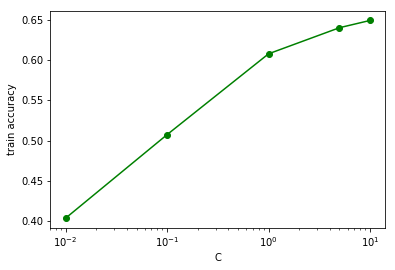

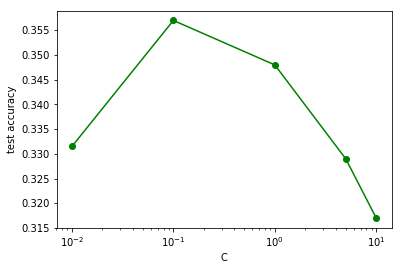

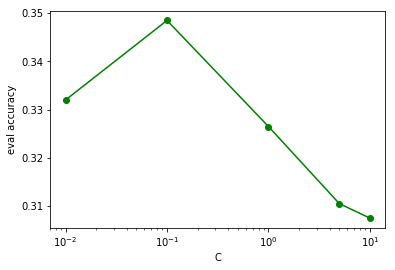

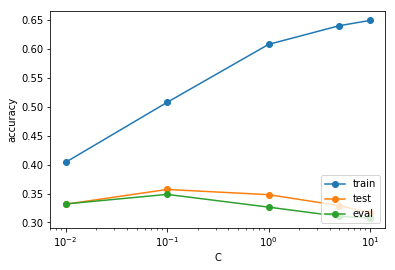

In [15]:
ORIGINAL_DATA_DIR, BERT_FEATURE_DIR, IMAGE_DATA_DIR = set_up()
print("Data Directory provided in the handout is: %s" % ORIGINAL_DATA_DIR)
print("Data Directory where feature vectors generated by bert extract_features.py are saved is: %s" % BERT_FEATURE_DIR)
print("Image Directory is: %s" % IMAGE_DATA_DIR)

train_df = read_csv(ORIGINAL_DATA_DIR, "lang_id_train.csv")
test_df = read_csv(ORIGINAL_DATA_DIR, "lang_id_test.csv")
eval_df = read_csv(ORIGINAL_DATA_DIR, "lang_id_eval.csv")

bert_vectors = load_bert_features(["train", "test", "eval"], BERT_FEATURE_DIR)

cs = [.01, .1, 1, 5, 10]
clf, accuracies = compare_c(bert_vectors, train_df, test_df, eval_df, image_dir=IMAGE_DATA_DIR, cs=cs)

In [16]:
#Create model with best parameters.
# We pick the c that provided the best accuracy on the test set so that we avoid overfitting over the trein set.
ind = np.argmax(accuracies["test"])
best_c_value = cs[np.argmax(accuracies["test"])]
clf, results = train_and_evaluate_model(bert_vectors, train_df, test_df, eval_df, c=best_c_value)
print("Best c value was {} with accuracies:\n\
train acc={:.2f}%\t test acc={:.2f}%\t eval acc={:.2f}%".format(best_c_value,\
accuracies['train'][ind]*100, accuracies['test'][ind]*100, accuracies['eval'][ind]*100))

/home/agericke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/agericke/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best c value was 0.1 with accuracies:
train acc=50.75%	 test acc=35.70%	 eval acc=34.85%




===============================================TRAIN================================================
Results for dataset
Accuracy for train dataset: accuracy=50.75% 

Per Native Language metrics for dataset TRAIN.

LANGUAGE           PRECISION(%)       RECALL(%)  TOP MISS CLASS. LANGUAGE
ARABIC                   54.70%          55.33%                  Spanish
CANTONESE                44.62%          42.83%                 Mandarin
JAPANESE                 51.04%          57.17%                   Korean
KOREAN                   55.78%          50.67%                 Mandarin
MANDARIN                 41.08%          43.00%                Cantonese
POLISH                   52.30%          53.17%                  Russian
RUSSIAN                  52.79%          53.67%                   Polish
SPANISH                  52.71%          48.67%                   Polish
THAI                     58.24%          59.50%                 Mandarin
VIETNAMESE               44.62%          43.50%     

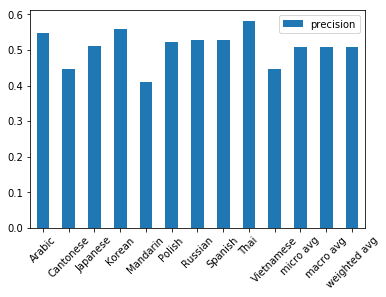

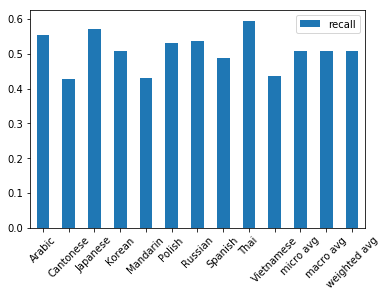

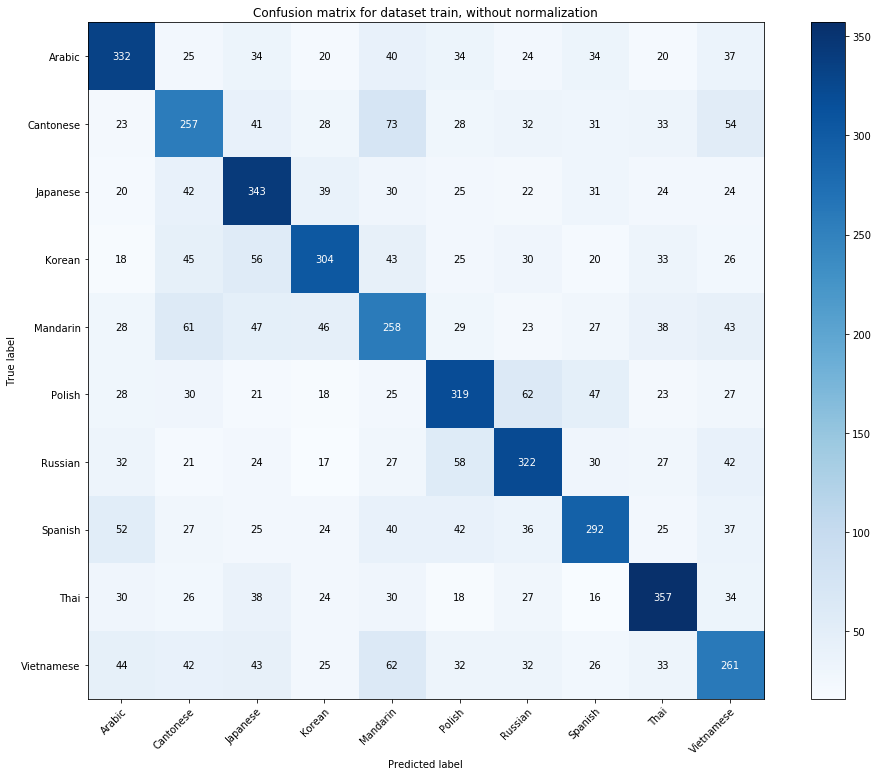

Normalized confusion matrix


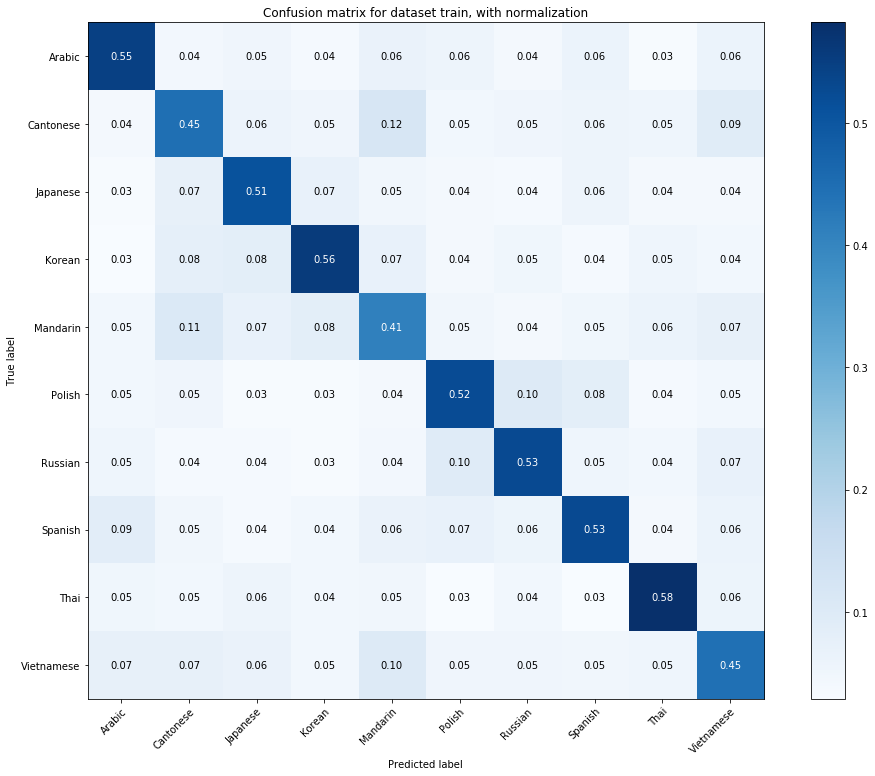

In [46]:
# 5 - Output results for each dataset and analyse per native language results.
for dataset in ['train']:
    print('\n\n{:=^100s}'.format(dataset.upper()))
    print('Results for dataset')
    # 5-1 - Print overall accuracy.
    print_accuracy_results(results, dataset)
    # 5-2 - Print metrics for each native language.
    print_per_lang_metrics(results, IMAGE_DATA_DIR, dataset)
    # 5-3 - Generate confusion matrices, both normalized and not normalized.
        # Plot non-normalized confusion matrix
    plot_confusion_matrix(
        results[dataset]["conf_matrix"],\
        classes=unique_labels(test_df["native_language"].values),\
        filename=os.path.join(IMAGE_DATA_DIR,'conf_matrix_{}'.format(dataset)),\
        title='Confusion matrix for dataset {}, without normalization'.format(dataset))
        # Plot normalized confusion matrix
    plot_confusion_matrix(
        results[dataset]["conf_matrix"],\
        classes=unique_labels(test_df["native_language"].values),\
        filename=os.path.join(IMAGE_DATA_DIR,'conf_matrix_{}'.format(dataset)),\
        normalize=True,\
        title='Confusion matrix for dataset {}, with normalization'.format(dataset))

In [35]:
a = results['train']['conf_matrix']
b = a/a.sum(axis=0)

In [36]:
b

array([[0.54695222, 0.04340278, 0.05059524, 0.03669725, 0.06369427,
        0.0557377 , 0.03934426, 0.06137184, 0.03262643, 0.06324786],
       [0.03789127, 0.44618056, 0.0610119 , 0.05137615, 0.11624204,
        0.04590164, 0.05245902, 0.05595668, 0.05383361, 0.09230769],
       [0.03294893, 0.07291667, 0.51041667, 0.07155963, 0.0477707 ,
        0.04098361, 0.03606557, 0.05595668, 0.03915171, 0.04102564],
       [0.02965404, 0.078125  , 0.08333333, 0.55779817, 0.06847134,
        0.04098361, 0.04918033, 0.03610108, 0.05383361, 0.04444444],
       [0.0461285 , 0.10590278, 0.06994048, 0.08440367, 0.41082803,
        0.04754098, 0.03770492, 0.04873646, 0.06199021, 0.07350427],
       [0.0461285 , 0.05208333, 0.03125   , 0.03302752, 0.03980892,
        0.52295082, 0.10163934, 0.08483755, 0.03752039, 0.04615385],
       [0.05271829, 0.03645833, 0.03571429, 0.03119266, 0.04299363,
        0.09508197, 0.52786885, 0.05415162, 0.04404568, 0.07179487],
       [0.08566722, 0.046875  , 0.0372023